In [ ]:
# Goal: From a single plane (.tiff or .zarr), find the centroid in each cell. Specify a masked crop in which 
# pixels inside the cell labels are 1 and outside region is 0.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import moments_central
from skimage.draw import disk
import random
from glob import glob
import tifffile

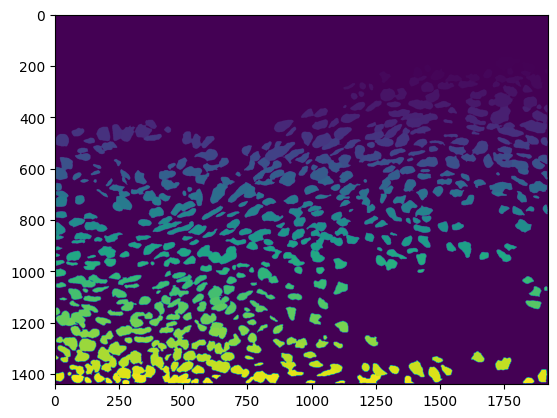

In [15]:
# import and view a tile 
# this tile was from running cellpose on all the tiles in the dataset (plane #6)

# grab filenames for raw images and masks
#raw_filenames = sorted(glob('/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/raw_files/*.tif'))
#mask_filenames = sorted(glob('/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/masks/*.tif'))

# choosing tile #12 to start, which looked reasonable:
raw_12 = tifffile.imread('/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/raw_files/raw_IF_XY01_00012_Z006_CH4.tif')
mask_12 = tifffile.imread('/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/masks/masks_IF_XY01_00012_Z006_CH4.tif')

# show images
plt.imshow(raw_12, cmap='gray_r')
plt.imshow(mask_12)

In [53]:
# Print shape to make sure dims make sense:
#print(raw_12.shape) # 1140,1920
print(mask_12.shape) # 1140,1920
#np.unique(raw_12)
np.unique(mask_12) # 0 is the background 

(1440, 1920)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [40]:
ids = np.unique(mask_12) # is a list 0 to 589; 588 cells bc background is 0
ids = ids[1:589] # only grabbing non-background

# Q: which x,y corresponds to i in ids?

centroids = []

for id in ids: 
    y,x = np.where(mask_12 == id)
    xm = np.mean(x)
    ym = np.mean(y)
    centroid = (ym, xm)
    centroids.append(centroid)

centroids = np.array(centroids)

print(centroids[1:5])
print(len(centroids)) # 588 makes sense 
print(centroids.shape) # 588, 2

[[ 187.06364513 1517.09064609]
 [ 189.70678921 1758.14230655]
 [ 206.98417068 1844.53269098]
 [ 211.27936508 1451.02698413]]
588


(1000.0, 1400.0)

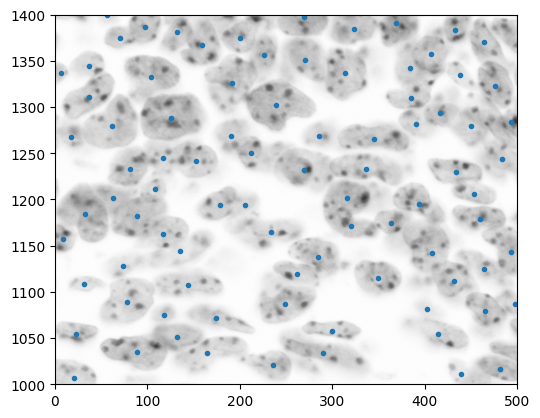

In [45]:
# visualize centroids:
plt.imshow(raw_12, cmap = 'gray_r')
plt.plot(centroids[:, 1], centroids[:, 0], '.')
plt.xlim([0, 500])
plt.ylim([1000, 1400])

In [58]:
# write a cropping function that takes centroid coordinates and returns starting position for a given center.

def crop_top_left(coord, size=156):
    x,y = coord
    x_top_left = int(x-(size//2))
    y_top_left = int(y-(size//2))
    return x_top_left, y_top_left
    

(588, 2)


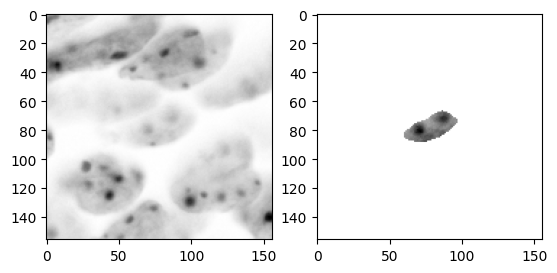

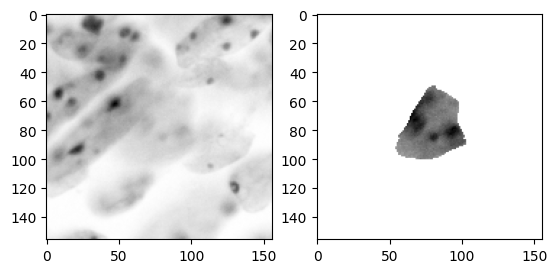

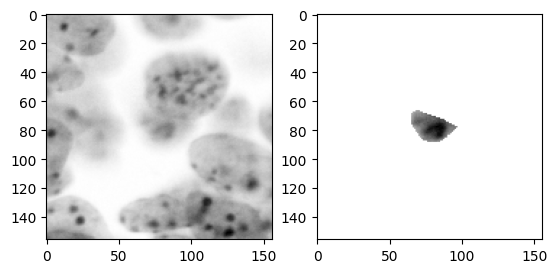

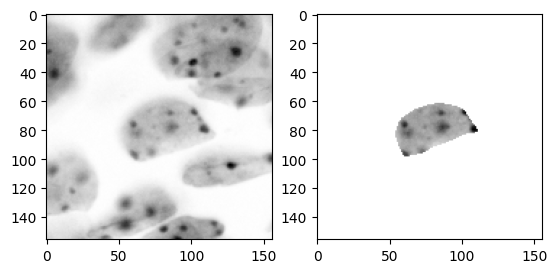

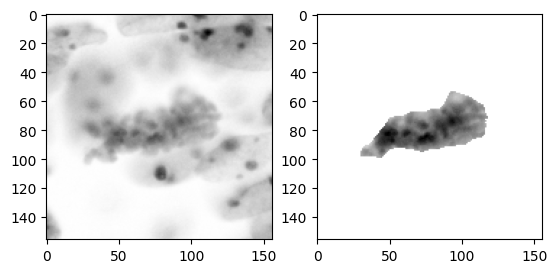

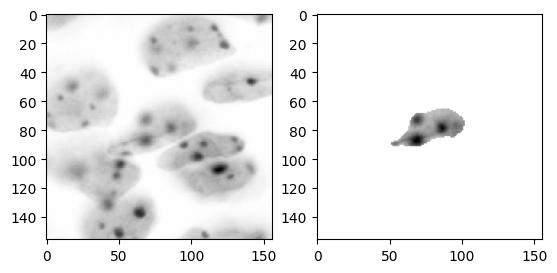

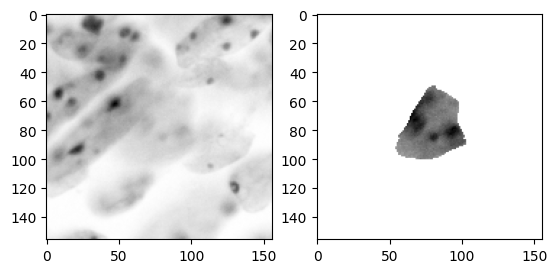

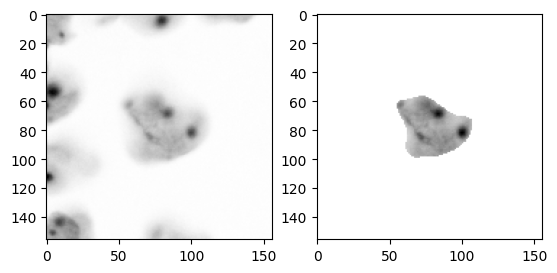

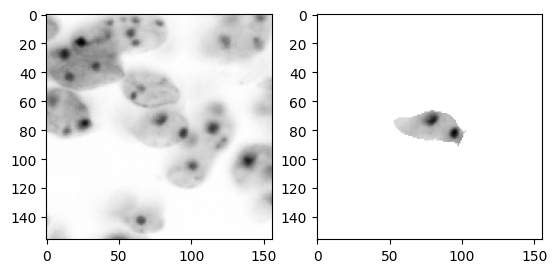

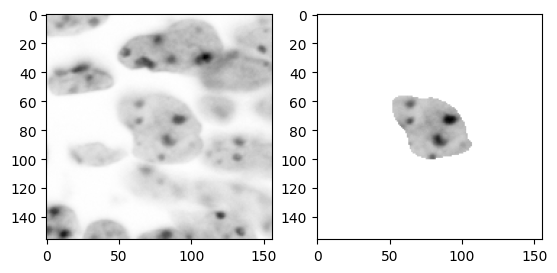

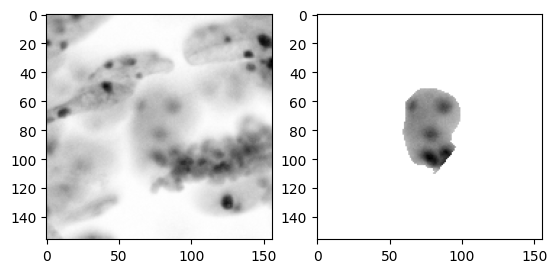

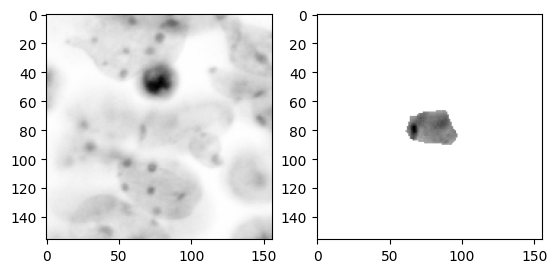

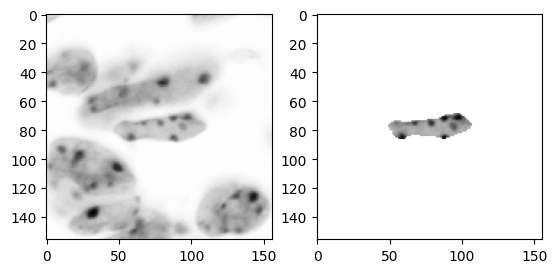

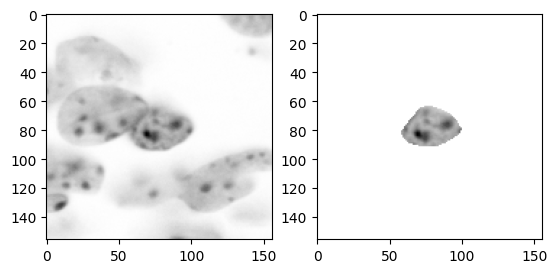

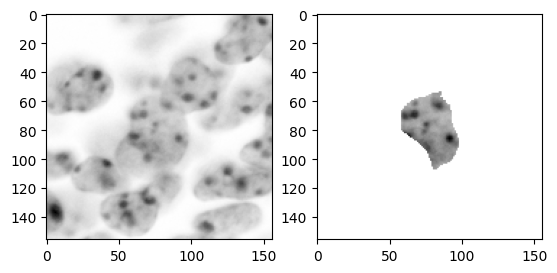

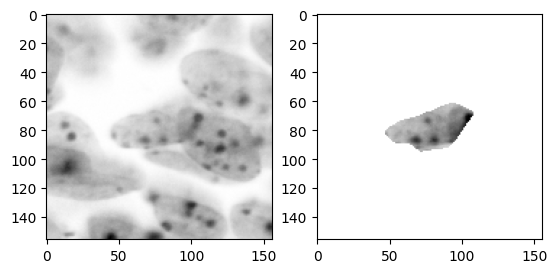

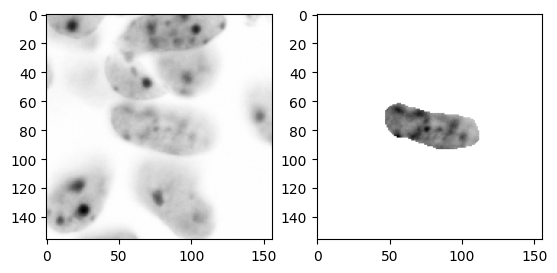

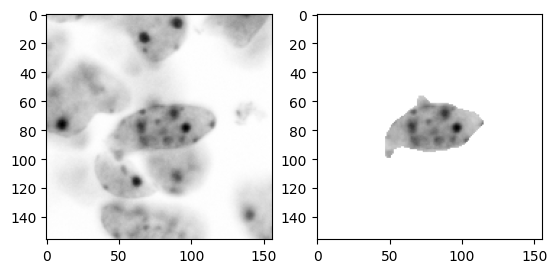

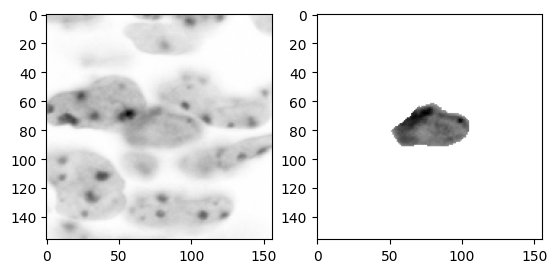

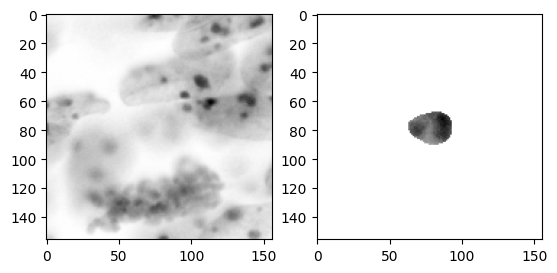

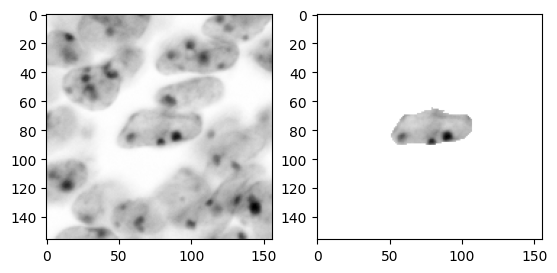

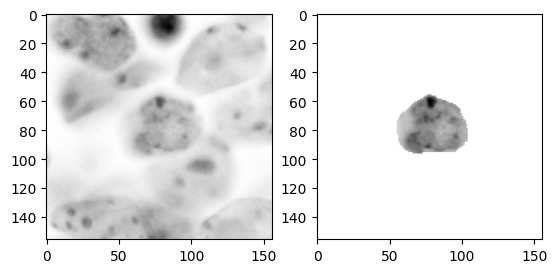

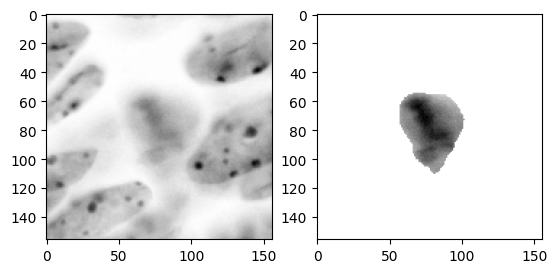

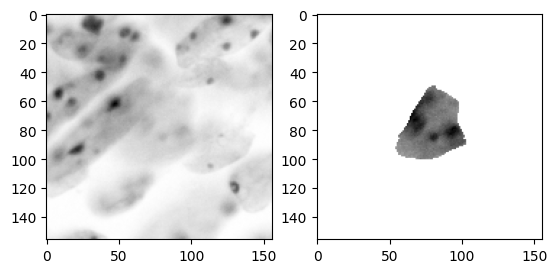

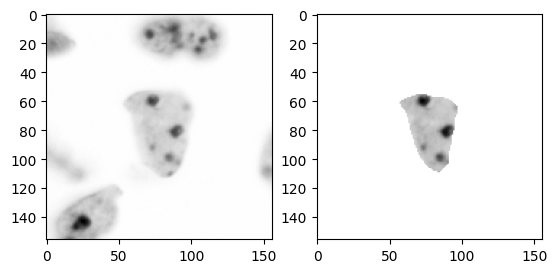

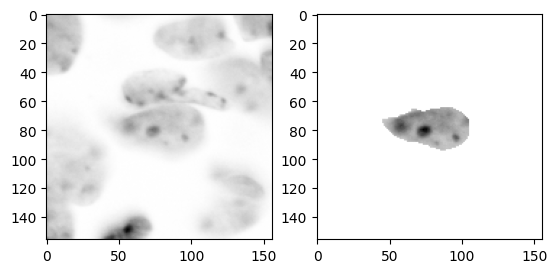

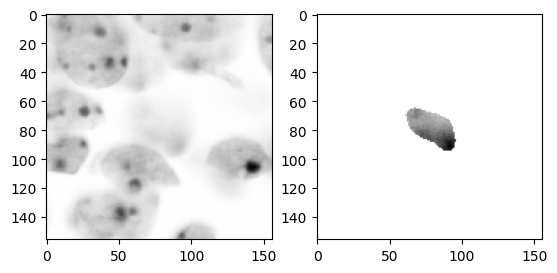

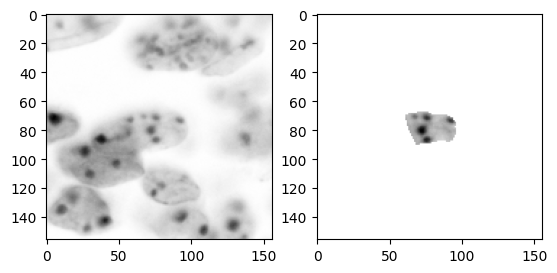

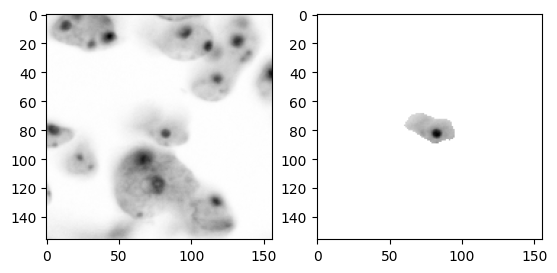

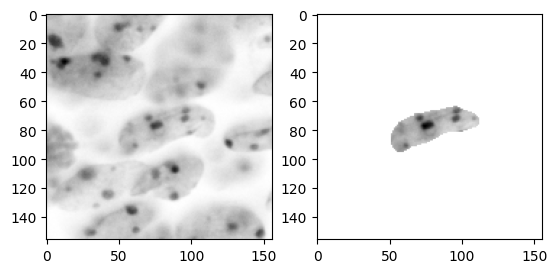

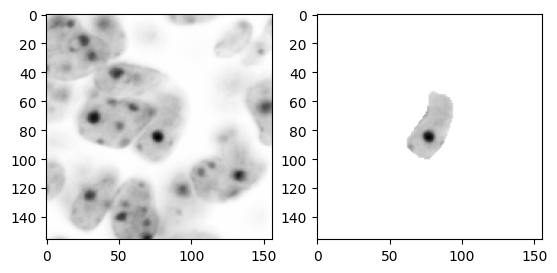

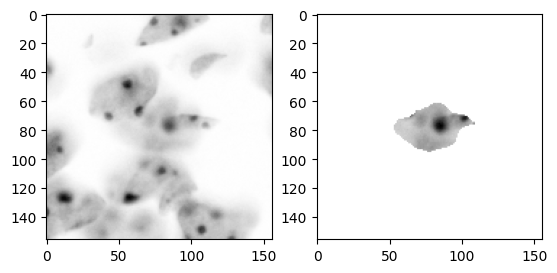

In [96]:
# Let's make generous crops around each mask 
# e.g., 150x150 or 75 around the center

# use mask_12 and centroids array
batch_size = 32
crops_masks = []
crops_raw = []
size = 156
#print(mask_12.shape)
print(centroids.shape)
while len(crops_masks) < batch_size: # only the first ten centroids
    centroid = random.choice(centroids)
    x_top_left, y_top_left = crop_top_left(centroid)

    #print(x_top_left, y_top_left)
    crop_mask = mask_12[x_top_left:x_top_left+size, y_top_left:y_top_left+size]
    if crop_mask.shape == (size, size):
        crop_mask = (crop_mask == crop_mask[int(size/2),int(size/2)])
        crop_raw = raw_12[x_top_left:x_top_left+size, y_top_left:y_top_left+size]
        #print(crop_raw.shape)
        plt.subplot(1,2,1)
        plt.imshow(crop_raw, cmap = 'gray_r')
        plt.subplot(1,2,2)
        plt.imshow(crop_raw*crop_mask, cmap = 'gray_r')
        plt.show()
        crops_masks.append(crop_mask)
        crops_raw.append(crop_raw)



In [98]:
import torch
from torch.utils.data import Dataset

# Creating a Dataset class

class EmbryoNucleiDataset(Dataset):
    def __init__(self,
                 root_dir,
                 crop_size,
                ):
        
        # using root_dir, split and mask create a path to files and sort it 
        self.mask_files = natsorted(glob(os.path.join(root_dir, 'masks', 'masks*.tif'))) # load mask files into sorted list
        self.raw_files = natsorted(glob(os.path.join(root_dir, 'raw_files', 'raw*.tif'))) # load image files into sorted list
    
    def __len__(self):
        return len(self.raw_files)

    def get_centroids(self, mask):
        ids = np.unique(mask)
        ids = ids[1:]
        centroids = []
        for id in ids:
            y,x = np.where(mask == id)
            xm = int(np.mean(x))
            ym = int(np.mean(y))
            centroid = (ym, xm)
            centroids.append(centroid)
        
        centroids = np.array(centroids)
        return centroids
    
    def crop_top_left(self, coord): 
        y,x = coord
        y_top_left = int(y-(self.crop_size//2))
        x_top_left = int(x-(self.crop_size//2))
        return y_top_left, x_top_left
    
    def get_masked_crop(self, raw, mask, batch_size):
        crops_raw = []
        crops_mask = []
        centroids = get_centroids(mask)
        
        while len(crops_masks) < batch_size: 
            centroid = random.choice(centroids)
            y_top_left, x_top_left = self.crop_top_left(centroid)
            crop_mask = mask[y_top_left:y_top_left+self.crop_size, x_top_left:x_top_left+self.crop_size]
            if crop_mask.shape == (self.crop_size, self.crop_size):
                crop_mask = (crop_mask == crop_mask[int(self.crop_size//2), int(self.crop_size//2)])
                crop_raw = raw[x_top_left:x_top_left+self.crop_size, y_top_left:y_top_left+self.crop_size]
                crops_raw.append(crop_raw*crop_mask)
                crops_mask.append(crop_mask)
        return crops_raw, crops_mask 
    
    def __getitem__(self, idx):
        raw_file = self.raw_files[idx] 
        mask_file = self.mask_files[idx] 
        
        raw = imread(raw_file) # load raw to numpy array
        mask = imread(mask_file) # load mask to numpy array

        # from (H, W) mask extract (B, h, h)
        crops_raw, crops_mask = get_masked_crops(raw, mask)

        # need to cast to float32
        crops_mask = (crops_mask !=0).astype(np.float32)
        crops_raw = (crops_raw != 0).astype(np.float32)
        
        # add channel dimensions to comply with pytorch standard (B, C, H, W) 
        crops_raw = np.expand_dims(crops_raw, axis=1)
        crops_mask = np.expand_dims(crops_mask, axis=1)
        
        return crops_raw, crops_mask
